# Functional model

In [49]:
#TODO: printing methods
#TODO: use Enums (?)
#TODO return self in population methods for chaining
#TODO remove unnecessary kwargs defaults (eg Population() should return an empty population, not one with size 10000)
#TODO black lines when plotting 'both' with 'day'
#TODO keep track of number filtered or % filtered
#Parameter_generator class for easy printing?
#TODO make sure population can't be re-generated after being sampled
#TODO raise error if generate() is called with generate_parameters=False but no parameters had been generated before either
#TODO don't return filtered Population nor filtered PopulationList if copy=False
#TODO improve plotting syntax and design with seaborn
#TODO replace all numpy data with pandas dataframe
#TODO create fig and axes by default if no axes given for plotting methods

In [27]:
import statsmodels.api as sm
from patsy import dmatrices

import pandas as pd

from math import ceil
from copy import copy
from warnings import warn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

from numpy import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)

In [28]:
# Simulations study parameters
FMIN = 6 #minimum possible visual score
SMIN = 0 #minimum possible symptom score
NDAYS = 160 #number of days in the study
FIRSTVISIT = 8
LASTVISIT = NDAYS-1

In [29]:
#helper functions
def truncatednormal(xmin, xmax, pmsigma=3, shape=(2,4)):
    '''the smaller the pmsigma, the closer the distribution is to uniform'''
    my_mean = (xmax+xmin)/2
    my_std = (xmax-xmin)/(2*pmsigma)
    
    vals = np.random.normal(my_mean, my_std, shape)
    invalid = np.flatnonzero((vals < xmin) | (vals >= xmax))
    
    while(len(invalid) > 0):
        vals.flat[invalid] = np.random.normal(my_mean, my_std, len(invalid))
        invalid = np.flatnonzero((vals < xmin) | (vals >= xmax))
        
    return vals

def rgblist_to_rgbapop(rgblist, npersons, ndays, opacity=1.0):
    '''
    takes a list of rgb colors with shape=(len,3) and turns it into an array of rgba colors with shape=(npersons, ndays, 4)
    where values change row-by-row (different persons) but are same across different columns (different days)
    '''
    listcopies = ceil(npersons/len(rgblist))
    rgblist_extended = np.tile(rgblist, (listcopies,1))[:npersons]
    rgbpop = np.tile(rgblist_extended, (1, 1, ndays)).reshape(npersons, ndays, 3)
    opacitypop = np.full((npersons, ndays, 1), opacity)
    rgbapop = np.concatenate([rgbpop, opacitypop], axis=2)
    return rgbapop

def normalize(array):
    return (array - np.min(array))/(np.max(array)-np.min(array))

#The following are useful for defining the PopulationList class
#They must be used after Population class has been defined

def assertPopulation(obj):
    """Check if object is a Population"""
    if not isinstance(obj, Population):
        raise AssertionError("object {} is {} instead of {}".format(obj, type(obj), type(Population())))
    return True #if no error
def assertListlikeOfPopulations(listlike):
    """Check if all objects are Populations"""
    for (i, obj) in enumerate(listlike):
        try: 
            assertPopulation(obj)
        except AssertionError as e:
            newmessage = "At index {}, {}".format(i, e.args[0])
            #append update error message
            if len(e.args) >= 1:
                e.args = (newmessage,) + e.args[1:]
            raise #re-raise error with updated message
    return True #if no error

In [30]:
class Population:
    def __init__(self, npersons=10000, title=''):
        
        self.title = title
        self.initial_data_shape = (self.initial_npersons, self.initial_ndays) = (npersons, NDAYS)
        
        self.parameter_generators = {}
        self.parameters = {}
        self.function_generators = {}
        
        self.days = np.tile(np.arange(self.initial_ndays), (self.initial_npersons,1))
        self.scores = {'visual':None, 
                       'symptom_noerror':None, 
                       'symptom':None}
        
    @property
    def npersons(self):
        return self.days.shape[0]
    @property
    def ndays(self):
        return self.days.shape[1]
    @property
    def data_shape(self):
        return self.days.shape
    @property
    def nfiltered(self):
        return self.initial_npersons - self.npersons
    @property
    def ratio_filtered(self):
        try:
            return self.nfiltered/self.initial_npersons
        except ZeroDivisionError:
            return 0
    @property
    def nsampled(self):
        return self.initial_ndays - self.ndays
    @property
    def ratio_sampled(self):
        try:
            return self.nsampled/self.initial_ndays
        except ZeroDivisionError:
            return 0
        
    # Data generation methods

    def set_parameter_generator(self, paramname, func, paramtype):
        '''
        func must be a numpy function with the "shape" argument of the numpy function as the only argument to func
        paramtype must be either "population", "person", or "day"
        '''
        if func.__code__.co_varnames != ('shape',):
            raise ValueError("The function for parameter generation should only have 'shape' as an argument. "+
                             "Currently, it's arguments are: "
                            +", ".join(["'"+str(arg)+"'" for arg in func.__code__.co_varnames]))
        
        if paramtype == 'population':
            shape = (1,)
        elif paramtype == 'person':
            shape = (self.npersons, 1)
        elif paramtype == 'day':
            shape = self.days.shape # also equivalent to self.data_shape
        self.parameter_generators[paramname] = lambda: func(shape)
    def generate_parameters(self):
        '''
        generates all parameters
        if population was already generated, is resets the scores (since they were based on previous parameters)
        '''
        #generate
        for paramname in self.parameter_generators:
            self.parameters[paramname] = self.parameter_generators[paramname]()
        #reset previous scores
        self.scores = {scorename:None for scorename in self.scores}   
    
    def set_score_generator(self, scorename, func):
        '''scorename is either visual, symptom_noerror, or symptom'''
        if scorename not in self.scores: warn("Scorename '{}' not known. Known options are: {}".format(scorename, self.scores.keys()))
        self.function_generators[scorename] = func
    def generate_from_score_generator(self, scorename):
        '''scorename is either visual, symptom_noerror, or error'''
        try:
            func = self.function_generators[scorename]
        except KeyError as e:
            warn("There is no generator for '{}' score attached to this Population.".format(scorename))
            func = lambda: np.array([])
        paramnames = func.__code__.co_varnames
        paramvals = []
        for paramname in paramnames:
            #reserved parameters
            if paramname == 't' or paramname == 'day':
                paramvals.append(self.days)
            elif paramname == 'f' or paramname == 'visual':
                paramvals.append(self.scores['visual'])
            elif paramname == 's' or paramname == 'symptom_noerror':
                paramvals.append(self.scores['symptom_noerror'])
            #custom parameters
            else:
                paramvals.append(self.parameters[paramname])
        return func(*paramvals)
    
    #def generate_parameters(self) is above
    def generate(self, generate_parameters=True):
        if generate_parameters: self.generate_parameters()
        
        for scorename in self.scores: #cannot be done by dict comprehension since later dict values depend on previous ones
            self.scores[scorename] = self.generate_from_score_generator(scorename).astype(float)
        
        minvisualscore = np.min(self.scores['visual'], initial=FMIN) #initial arg to avoid error of min on empty array
        if minvisualscore < FMIN: 
            warn("visual score in {} has min={}, which is below FMIN={}".format(self.title, minscore, FMIN))
        minsymptomscore = np.min(self.scores['symptom'], initial=SMIN) #initial arg to avoid error of min on empty array
        if minsymptomscore < SMIN: 
            warn("symptom score in {} has  min={}, which is below SMIN={}".format(self.title, minscore, SMIN))
            
        #if all parameters are 'population', the generation process will only have created a single row
        #so, repeat that row 'self.npersons' times to create the full matrix            
        for scorename in self.scores:
            if self.scores[scorename].shape != self.data_shape and self.scores[scorename].size > 0: #if score array is wrong shape but nonzero
                self.scores[scorename] = np.broadcast_to(self.scores[scorename], self.data_shape) #change shape by broadcasting
            elif self.scores[scorename].size == 0: #if score array is empty
                self.scores[scorename] = self.scores[scorename].reshape(self.data_shape) #change shape by adding empty axes
                
    # Statistical methods
    
    def regress(self, y='symptom', x='visual', outputtype='full'):
        # TODO more complex model than linear
        # Argument parsing # TODO make into helper function for clutter reduction
        y_possibilities = {'symptom'} #TODO add more possibilities
        x_possibilities = {'visual'} #TODO add more possibilities
        if y not in y_possibilities:
            raise ValueError('Dependent variable {} not recognized. Use one of {} instead.'.format(y, y_possibilities))
        if x not in x_possibilities:
            raise ValueError('Independent variable {} not recognized. Use one of {} instead.'.format(x, yx_possibilities))
            
        y, X = dmatrices(y+' ~ '+x, data=self.to_dataframe(), return_type='dataframe') #split into endogenous and exogenous
        model = sm.OLS(y, X) #define model
        result = model.fit() #fit model
        
        if outputtype == 'summary': return result.summary()
        elif outputtype == 'params and r-squared': return result.params.append(pd.Series({'Rsquared': result.rsquared})) #TODO more info like confidence intervals
        #TODO have 'shortsummary' outputtype
        else: #full
            if outputtype != 'full':
                warn('Outputtype argument "{}" not recognized. Used "full" by default'.format(outputtype))
            return result
    
    # Other methods
        
    def copy(self, newtitle=None, addtitle=None):
        '''not fully deep, but allows re-generation and filtering'''
        newpop = copy(self) #python shallow copy
        if newtitle is not None:
            newpop.title = newtitle
        if addtitle is not None:
            newpop.title += ' '+addtitle
        newpop.parameter_generators = copy(self.parameter_generators)
        newpop.function_generators = copy(self.function_generators)
        newpop.scores = copy(self.scores)
        return newpop
    def double(self, newtitle1=None, addtitle1=None, newtitle2=None, addtitle2=None):
        newpop2 = self.copy(newtitle=newtitle2, addtitle=addtitle2)
        newpop1 = self
        if newtitle1 is not None:
            newpop1.title = newtitle1
        if addtitle1 is not None:
            newpop1.title += ' '+addtitle1
        return newpop1, newpop2
    def to_dataframe(self):
        data_dict = {
            'person': np.broadcast_to(np.arange(self.npersons), (self.ndays, self.npersons)).T, # same shape matrix as days or scores, with values that indicate person index
            'day': self.days,
            **self.scores
        }
        dataflat_dict = {dataname: data.flatten() for (dataname,data) in data_dict.items()}
        df = pd.DataFrame(dataflat_dict)
        df.index.name = 'observation'
        return df
    
    #removing outliers
    def filter(self, recovered_symptom_score=SMIN, firstday=FIRSTVISIT, lastday=NDAYS, copy=False):
        if copy==False: pop=self
        elif copy==True: pop=self.copy(addtitle='filtered')
        else: raise ValueError()
        
        persons_recovered_early = np.any(pop.scores['symptom'][:,:firstday] <= recovered_symptom_score, axis=1)
        persons_recovered_late = np.min(pop.scores['symptom'][:,:lastday], axis=1) > recovered_symptom_score
        persons_excluded = np.logical_or(persons_recovered_early, persons_recovered_late)
        persons_included = np.logical_not(persons_excluded)

        #take only the included and recalculate size
        pop.scores = {scorename:pop.scores[scorename][persons_included] for scorename in pop.scores}
        pop.days = pop.days[persons_included]
        
        return pop #may be self or a copy
    
    #plotting
    def plot(self, ax, ndays=None, npersons=None, x='day', y='symptom', viztype='lines', vizcolor='person'):
        #x and y are either 'day' or a scorename (either 'visual', 'symptom_noerror', or 'symptom')
        #viztype is either 'lines', 'points', or 'both'
        #vizcolor is either 'person' (each person is a color) or 'day' (each day is a color)
        #TODO raise exception for non-existant viztype
        
        if ndays is None: ndays=self.ndays
        if npersons is None: npersons=self.npersons
            
        if (viztype=='lines' or viztype=='both') and vizcolor=='day':
            warn('vizcolor of "day" can only be applied to points, not lines')
        if vizcolor != 'person' and vizcolor != 'day':
            raise ValueError()
            
        #abscissas
        if x=='day':
            x = self.days[:npersons, :ndays]
            xlabel='days since concussion'
        elif x in self.scores:
            xlabel = x+' scores'
            x = self.scores[x][:npersons, :ndays]
        else:
            raise ValueError()
            
        #ordinates
        if y=='day':
            x = self.days[:npersons, :ndays]
            ylabel='days since concussion'
        elif y in self.scores:
            ylabel = y+' scores'
            y = self.scores[y][:npersons, :ndays]
        else:
            raise ValueError()
            
        #titles and labels
        ax.set(title=self.title, xlabel=xlabel, ylabel=ylabel)
        
        #plotting
        if viztype=='lines' or viztype=='both':
            points = np.stack([x, y], axis=2)
            colors = mpl.cm.get_cmap('Dark2').colors # https://matplotlib.org/2.0.1/users/colormaps.html
            ax.add_collection(LineCollection(points, colors=colors))
            
        if viztype=='points' or viztype=='both':
            if vizcolor == 'person':
                colors = np.array(mpl.cm.get_cmap('Dark2').colors) # not the right shape. https://matplotlib.org/2.0.1/users/colormaps.html
                colors = rgblist_to_rgbapop(colors, npersons, ndays)
                colors = colors.reshape(npersons*ndays, 4) #scatter converts the 2d arrays x and y to flat arrays, and colors should respect that flatness
            elif vizcolor == 'day':
                colors = self.days[:npersons, :ndays]
                cmap = mpl.cm.get_cmap('viridis') # https://matplotlib.org/2.0.1/users/colormaps.html
                colors = cmap(normalize(colors)) # converts scalars to rgba
                colors = colors.reshape(npersons*ndays, 4) #scatter converts the 2d arrays x and y to flat arrays, and colors should respect that flatness
            else:
                raise ValueError("vizcolor of '{}' unknown".format(vizcolor))
            ax.scatter(x, y, facecolors='none', edgecolors=colors)
        ax.autoscale()

In [38]:
from collections import UserList

class PopulationList(UserList):
    def __init__(self, listlike=[]):
        assertListlikeOfPopulations(listlike)
        super().__init__(listlike)
    #overriden methods
    def append(self, other):
        assertPopulation(other)
        super().append(other)
    def extend(self, listlike):
        assertListlikeOfPopulations(listlike)
        super().extend(listlike)
    def insert(self, i, obj):
        assertPopulation(obj)
        super().insert(i, obj)
        
    # Properties which iterate over the respective attributes for all Populations in the list
    
    @property
    def titles(self):
        return [pop.title for pop in self]
    @property
    def npersons(self):
        return [pop.npersons for pop in self]
    @property
    def ndays(self):
        return [pop.ndays for pop in self]
    @property
    def data_shapes(self):
        return [pop.data_shape for pop in self]
    @property
    def nfiltered(self):
        return [pop.nfiltered for pop in self]
    @property
    def ratio_filtered(self):
        return [pop.ratio_filtered for pop in self]
    @property
    def nsampled(self):
        return [pop.nsampled for pop in self]
    @property
    def ratio_sampled(self):
        return [pop.ratio_sampled for pop in self]
    @property
    def parameter_generators(self):
        return [pop.parameter_generators for pop in self]
    @property
    def parameters(self):
        return [pop.parameters for pop in self]
    @property
    def function_generators(self):
        return [pop.function_generators for pop in self]
    @property
    def days(self):
        return [pop.days for pop in self]
    @property
    def score_dicts(self):
        '''list of the "scores" dict of all populations'''
        return [pop.scores for pop in self]
    @property
    def dict_scores(self):
        '''dict where each entry is a scoretype, and each value is a list of that score for each population'''
        return {scorename:[pop.scores[scorename] for pop in self] for scorename in ['visual', 'symptom_noerror', 'symptom']}
    
    # Data generation methods
    
    def generate_parameters(self):
        for pop in self: pop.generate_parameters()
    def generate(self, generate_parameters=True):
        for pop in self: pop.generate(generate_parameters=generate_parameters)
            
    # Statistical methods
            
    def regress(self, **kwargs):
        return [pop.regress(**kwargs) for pop in self]
            
    # Other methods
    
    def copy(self, newtitle=None, addtitle=None):
        return PopulationList([pop.copy(newtitle=newtitle, addtitle=addtitle) for pop in self])
    def double(self, newtitle1=None, addtitle1=None, newtitle2=None, addtitle2=None):
        newpoplist2 = self.copy(newtitle=newtitle2, addtitle=addtitle2)
        newpoplist1 = self
        if newtitle1 is not None:
            for newpop1 in newpoplist1: newpop1.title = newtitle1
        if addtitle1 is not None:
            for newpop1 in newpoplist1: newpop1.title += ' '+addtitle1
        return newpoplist1, newpoplist2
    def to_dataframes(self):
        return [pop.to_dataframe() for pop in self]
    
    def filter(self, recovered_symptom_score=SMIN, firstday=FIRSTVISIT, lastday=NDAYS, copy=False):
        if copy==False: poplist=self
        elif copy==True: poplist=self.copy(addtitle='filtered')
        else: raise ValueError()
        
        poplist.data = [pop.filter(recovered_symptom_score=recovered_symptom_score, firstday=firstday, lastday=lastday, copy=copy) for pop in poplist]
        
        return poplist #may be self or a copy
    
    def plot(self, axes, **kwargs):
        '''plots all populations sequentially, using same kwargs as in Population.plot() method'''
        #check axes input
        axes = axes.flatten()
        if len(axes) != len(self): 
            raise ValueError("{} axes are not enough to plot {} Populations".format(len(axes), len(self)))
        #plot
        for (i, pop) in enumerate(self):
                pop.plot(axes[i], **kwargs)

# Population generation

In [13]:
# Various functions to exemplify how to create populations

def get_default_pop(size=10000):
    pop = Population(size, 'default pop')        

    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 1
    pop.set_parameter_generator('r', gen_r , 'person')
    gen_f0 = lambda shape: 16
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a: a*(f-FMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: 1
    pop.set_parameter_generator('a', gen_a, 'population')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptom', gen_error_mult)
    gen_C = lambda shape: 1
    pop.set_parameter_generator('C', gen_C, 'day')

    return pop

def get_poster_pop(size=10000):
    pop = Population(size, 'poster pop')        

    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 2
    pop.set_parameter_generator('r', gen_r , 'population')
    gen_f0 = lambda shape: np.random.randint(14, 18+1, size=shape)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a,s0: np.maximum(a*f+s0, SMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: 1
    pop.set_parameter_generator('a', gen_a, 'population')
    gen_s0 = lambda shape: np.random.normal(6, 2, size=shape)
    pop.set_parameter_generator('s0', gen_s0, 'person')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptom', gen_error_mult)
    gen_C = lambda shape: 1 + np.random.choice([-1, 1], size=shape)*(np.random.randint(0, 30, size=shape)/100)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_prevsim_pop(size=10):
    pop = Population(size, 'previous simulation - basic pop')
    
    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 1
    pop.set_parameter_generator('r', gen_r , 'population')
    gen_f0 = lambda shape: truncatednormal(14, 18, 3, shape)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a: a*(f-FMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: random.choice([1, 2, 3], shape)
    pop.set_parameter_generator('a', gen_a, 'person')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptom', gen_error_mult)
    gen_C = lambda shape: truncatednormal(0.8, 1.2, 3, shape)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_linpop(size=10000):
    pop = get_default_pop(size)
    pop.title = 'linear population with multiplicative error'
    
    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptom', gen_error_mult)
    gen_C = lambda shape: truncatednormal(0.7, 1.3, 3, shape)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_exppop(size=10000):
    pop = get_linpop(size)
    pop.title = 'exponential population with multiplicative error'
    
    #symptom score no error
    gen_symptomscores = lambda f,a,f0,B: a*(f0-FMIN)*(B**f-B**FMIN)/(B**f0-B**FMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_B = lambda shape: np.full(shape=shape, fill_value=1.5)
    pop.set_parameter_generator('B', gen_B, 'population')
    
    return pop

In [46]:
pop_with_visual_score = Population(100)
gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
pop_with_visual_score.set_score_generator('visual', gen_visualscores)
gen_r = lambda shape: truncatednormal(1/15, 31/15, 1, shape)
gen_f0 = lambda shape: truncatednormal(14, 18, 1, shape)
pop_with_visual_score.set_parameter_generator('r', gen_r, 'person')
pop_with_visual_score.set_parameter_generator('f0', gen_f0, 'person')

linear_pop = pop_with_visual_score.copy(newtitle='linear')
gen_symptomscores = lambda f,a: a*(f-FMIN)
linear_pop.set_score_generator('symptom_noerror', gen_symptomscores)
gen_a = lambda shape: 1
linear_pop.set_parameter_generator('a', gen_a, 'population')

exponential_pop = linear_pop.copy(newtitle='exponential')
gen_symptomscores = lambda f,a,f0,B: a*(f0-FMIN)*(B**f-B**FMIN)/(B**f0-B**FMIN)
exponential_pop.set_score_generator('symptom_noerror', gen_symptomscores)
exponential_pop.set_parameter_generator('a', gen_a, 'population')

B = 1.5
exponential_quick_pop, exponential_slow_pop = exponential_pop.double(addtitle1='quick', addtitle2='slow')
exponential_quick_pop.set_parameter_generator('B', lambda shape: B, 'population')
exponential_slow_pop.set_parameter_generator('B', lambda shape: 1/B, 'population')

gen_error_mul = lambda s,C: s*C
gen_C_mul = lambda shape: truncatednormal(0.7, 1.3, 1, shape)
gen_error_add = lambda s,C: np.maximum(s+C, SMIN)
gen_C_add = lambda shape: truncatednormal(-1, 1, 1, shape)


pops_noerror = PopulationList([linear_pop, exponential_quick_pop, exponential_slow_pop])
pops_mulerror = PopulationList()
pops_adderror = PopulationList()

for i in range(len(pops_noerror)):
    pop_mul, pop_add = pops_noerror[i].double(addtitle1='multiplicative error', addtitle2='additive error')
    
    pop_mul.set_score_generator('symptom', gen_error_mul)
    pop_mul.set_parameter_generator('C', gen_C_mul, 'day')
    pops_mulerror.append(pop_mul)
    
    pop_add.set_score_generator('symptom', gen_error_add)
    pop_add.set_parameter_generator('C', gen_C_add, 'day')
    pops_adderror.append(pop_add)
    
pops_mulerror.generate()
pops_adderror.generate()

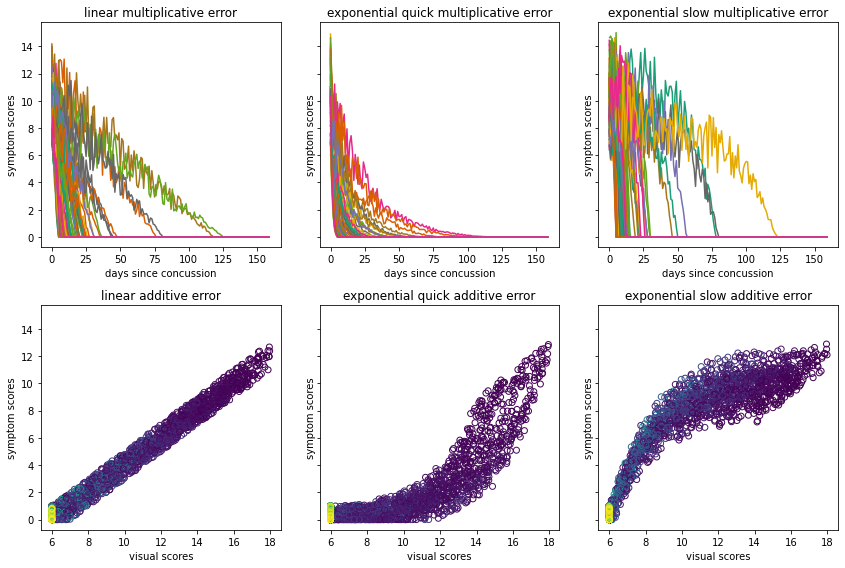

In [47]:
ncols = len(pops_noerror)
nrows = len([pops_mulerror, pops_adderror])

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharey=True)
npersons=None
ndays=None

pops_mulerror.plot(axes[0, :], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
pops_adderror.plot(axes[1, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

# Study

In [57]:
#TODO check score percentage not only first dip, but multiple consecutive days
#TODO parallelize
    
class Methodology:
    def __init__(self, title='', sample_args=[8, 15, 29], smilescorename='symptom'):
        '''
        Sample args that are integers are interpreted as a fixed day
        Sample args between 0 and 1 (exclusive) are interpreted as a percentage with which to use SMILE, based on the first fixed day
        Sample args that do not fit the above criteria are ignored
        smilescore determines which score the milestone_ratios will be based on (can be symptom, visual, or symptom_noerror)
        '''
        
        self.title=title
        self.smilescorename=smilescorename
        
        sample_args = np.array(sample_args)
        self.fixed_days = sample_args[sample_args == sample_args.astype(int)].astype(int)
        self.milestone_ratios = sample_args[(0 < sample_args) & (sample_args < 1)]
        
        if self.fixed_days.size==0: 
            raise Exception("No fixed days in sample_args, which were {}".format(sample_args))
        
        if np.max(self.fixed_days) >= NDAYS:
            raise Exception("There is a fixed sample day in {} that is later than the LASTVISIT of {}".format(self.fixed_days, NDAYS))
        if np.max(self.fixed_days) > LASTVISIT:
            warn("There is a fixed sample day in {} that is later than the LASTVISIT of {}".format(self.fixed_days, LASTVISIT))
        if np.min(self.fixed_days) < FIRSTVISIT:
            warn("There is a fixed sample day in {} that is earlier than the FIRSTVISIT of {}".format(self.fixed_days, FIRSTVISIT))
        
    # Statistical
    
    def sample(self, pop_or_poplist, filter_args=None):
        #if population is a PopulationList, apply the single-population version to all
        if isinstance(pop_or_poplist, PopulationList): 
            poplist = pop_or_poplist #renaming
            return PopulationList([self.sample(pop, filter_args=filter_args) for pop in poplist])
        else:
            population = pop_or_poplist #renaming
            
            #possible filtering
            if filter_args is not None: population = population.filter(**filter_args, copy=True)

            # MILESTONES        

            smilescores = population.scores[self.smilescorename]

            index = np.min(self.fixed_days) #day which milestone_ratios are based on
            smilescores_at_index = smilescores[:, index].reshape(-1, 1) #reshape to be vertical
            smile_vals = smilescores_at_index*self.milestone_ratios #The score values to reach. Each row is a person, each column is a milestone

            milestone_days = np.empty_like(smile_vals, dtype=int) #will hold the day each milestone_ratio is reached for each person
            for milestone_col in range(smile_vals.shape[1]):
                milestone_vals = smile_vals[:,milestone_col].reshape(-1, 1) #reshape to be vertical
                milestone_days[:,milestone_col] = np.argmax(smilescores <= milestone_vals, axis=1).astype(int) #the day at which the milestone is reached for each person
            #careful: values of 0 in milestone_days might represent 'day 0' or might represent 'never reached milestone'

            #Sample at those days
            milestone_smilescores = np.take_along_axis(smilescores, milestone_days, axis=1)
            milestone_scores = {scorename:np.take_along_axis(population.scores[scorename], milestone_days, axis=1) for scorename in population.scores}
            #replace the 'fake' days and scores with NaN
            notFake = (milestone_smilescores <= smile_vals)
            milestone_days = np.where(notFake, milestone_days, np.nan)
            milestone_scores = {scorename:np.where(notFake, milestone_scores[scorename], np.nan) for scorename in milestone_scores}

            # FIXED

            fixed_days = np.tile(self.fixed_days, (smilescores.shape[0],1)) #same shape as milestone_days
            fixed_scores = {scorename:np.take_along_axis(population.scores[scorename], fixed_days, axis=1) for scorename in population.scores}

            # COMBINE fixed and milestones

            samplepop = population.copy(addtitle='samples')
            samplepop.days = np.concatenate([fixed_days, milestone_days], axis=1)
            samplepop.scores = {scorename:np.concatenate([fixed_scores[scorename], milestone_scores[scorename]], axis=1) for scorename in samplepop.scores}

            return samplepop
                 
    #TODO compare_analysis classmethod

## Comparing traditional studies

In [78]:
methodologies = [Methodology('trad short', [8, 15, 29]), Methodology('trad long', [8, 29, 90])]

meth_pops = []
for methodology in methodologies:
    meth_pops.append(methodology.sample(pops_mulerror))

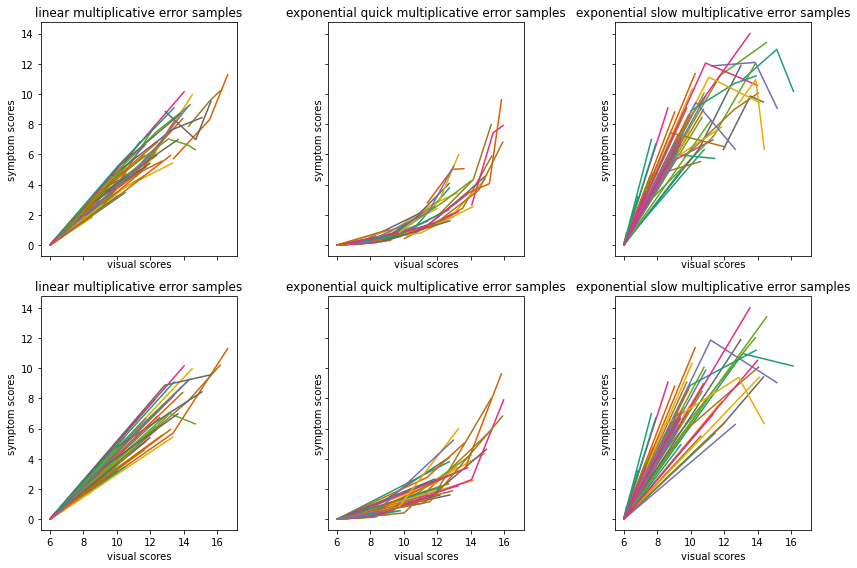

In [79]:
#TODO study name when plotting
ncols = len(meth_pops[0])
nrows = len(meth_pops)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops[row].plot(axes[row, :], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

## Comparing traditional to smile studies

In [80]:
methodologies = [Methodology('trad short', [8, 15, 29, 90]), Methodology('smile', [8, 0.7, 0.4, 0.1])]

meth_pops2 = []
for methodology in methodologies:
    meth_pops2.append(methodology.sample(pops_mulerror))

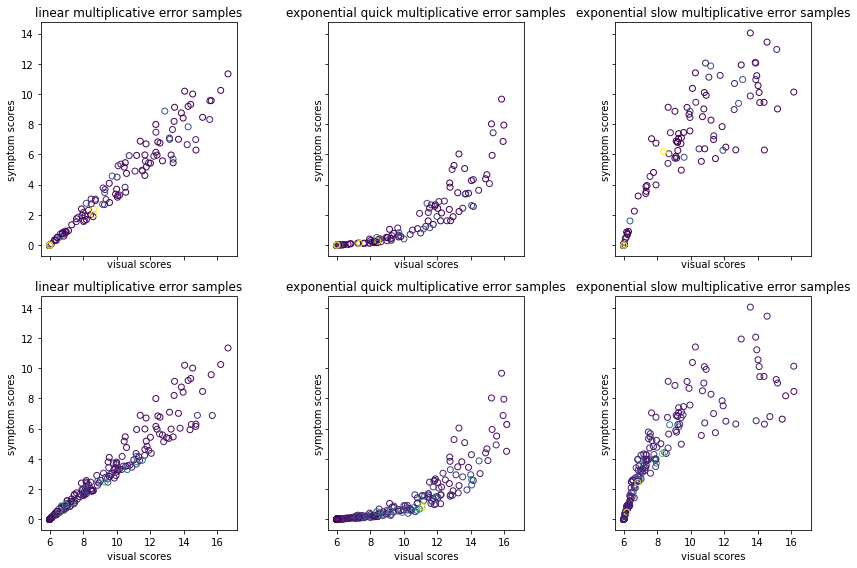

In [86]:
ncols = len(meth_pops2[0])
nrows = len(meth_pops2)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops2[row].plot(axes[row, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

## Regression test

In [91]:
ncols = len(meth_pops2[0])
nrows = len(meth_pops2)

for row in range(nrows):
    reslist = meth_pops2[row].regress(x='visual', y='symptom', outputtype='params and r-squared')
    for res in reslist: 
        print(res)
        print()
    print("==================================================================")
    print("==================================================================")
    print()

Intercept   -5.977906
visual       0.996699
Rsquared     0.972451
dtype: float64

Intercept   -3.021947
visual       0.487296
Rsquared     0.797804
dtype: float64

Intercept   -8.789103
visual       1.496811
Rsquared     0.891705
dtype: float64


Intercept   -5.478931
visual       0.911535
Rsquared     0.954145
dtype: float64

Intercept   -2.758829
visual       0.430039
Rsquared     0.749609
dtype: float64

Intercept   -7.193440
visual       1.291096
Rsquared     0.798031
dtype: float64


